## 1. Importing packages and defining some useful functions

In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
sns.set_style('whitegrid') # set style for visualization
warnings.filterwarnings('ignore')


In [2]:
def compare_timeseries(x1,y1,name1,x2,y2,name2):
    '''
    x1,y1: time series 1
    x2,y2: time series 2
    '''
    
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel(name1, color=color) #First X-Axis label
    ax1.plot(x1, y1, color=color) #First time series
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.tick_params(axis='x',rotation=45)
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    color = 'tab:blue'
    ax2.set_ylabel(name2, color=color) #Second X-axis label
    ax2.plot(x2, y2, color=color)  #Second time series
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.tick_params(axis='x',rotation=45)
    
    fig.tight_layout()
    plt.show()

In [3]:
def plot_timeseries(x,y,graph_name,axv_value,axv_name):
    '''
    x,y: time series
    graph_name: title of graph
    axv_value: string date value of verticle line to plot
    axv_name: label of vertical line
    '''
    
    fig, ax = plt.subplots()

    color = 'tab:red'
    ax.set_xlabel('Date')
    ax.set_ylabel(graph_name, color=color) #X-Axis label
    ax.plot(x, y, color=color) #time series
    ax.tick_params(axis='y', labelcolor=color)
    ax.axvline(pd.to_datetime(axv_value), color = 'black', label = axv_name) #Line
    fig.tight_layout()
    plt.show()

In [4]:
def single_variable_barplot(df,feature,p_color,percentile):
    '''
    Plot bar plot for single variable
    df: dataframe
    feature: feature name
    p_color: primary color of bar plot
    percentile: percentile to highlight (e.g. 0.75)
    '''
    data = df[feature].groupby(df.index.month).mean()
    threshold = data.quantile(percentile)
    data.plot(kind="bar",color=[p_color if x > threshold else '0.8' for x in data])
    plt.axhline(threshold, color='red', linestyle='solid', linewidth=1.1)
    plt.title(f'Months of {feature}')
    plt.ylabel(f'{feature}')
    plt.xlabel('Month')


## 2. Reading and understanding the dataset

* Weekly nationwide dengue cases ranges from 38 to 1791 from 2018 to 2023
* Weekly dengue cases averages at 362
* DENV 1 and DENV 4 strains is usually low, with average below 10% of weekly dengue cases
* DENV_3 and DENV_2 averages about 40% of the weekly dengue cases
* Maximum weekly temperature is about 35 degree celcius
* Minimum weekly temperature is about 24 degree celcius
* Average weekly temperature is about 28 degree celcius
* Average weekly rainfall is about 5.9 mm, but the maximum is 78.2 mm 
* The anomalously high rainfall 78.2 mm comes from last week data (2023-03-05) is based on average of 2 days (27-Feb and 28-Feb 2023) due to lack of data.
* 28 Feb 2023 alone recorded 154 mm of rainfall

In [5]:
df = pd.read_csv('../datasets/merged_df2.csv')
df['time'] = pd.to_datetime(df['time'], format = '%Y-%m-%d')
df.set_index('time',inplace=True)
df.head()


,dengue_cases,denv_1,denv_2,denv_3,denv_4,Mean Temperature (°C),Mean Wind Speed (km/h),Daily Rainfall Total (mm),Maximum Temperature (°C),Max Wind Speed (km/h),Minimum Temperature (°C),google_trends
time,,,,,,,,,,,,
2018-04-08,38,0.000,0.505,0.484,0.011,28.528571,10.714286,0.742857,33.8,36.7,25.5,20
2018-04-15,56,0.000,0.505,0.484,0.011,28.914286,9.828571,2.057143,34.4,38.2,24.6,18
2018-04-22,55,0.000,0.505,0.484,0.011,28.142857,7.700000,0.371429,34.3,37.1,25.5,21
2018-04-29,74,0.000,0.505,0.484,0.011,28.414286,6.842857,4.800000,35.0,43.6,22.6,23
2018-05-06,62,0.029,0.549,0.382,0.039,28.785714,8.328571,3.742857,34.2,44.6,23.6,39


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 257 entries, 2018-04-08 to 2023-03-05
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   dengue_cases               257 non-null    int64  
 1   denv_1                     257 non-null    float64
 2   denv_2                     257 non-null    float64
 3   denv_3                     257 non-null    float64
 4   denv_4                     257 non-null    float64
 5   Mean Temperature (°C)      257 non-null    float64
 6   Mean Wind Speed (km/h)     257 non-null    float64
 7   Daily Rainfall Total (mm)  257 non-null    float64
 8   Maximum Temperature (°C)   257 non-null    float64
 9   Max Wind Speed (km/h)      257 non-null    float64
 10  Minimum Temperature (°C)   257 non-null    float64
 11  google_trends              257 non-null    int64  
dtypes: float64(10), int64(2)
memory usage: 26.1 KB


In [7]:
df.isnull().sum()

dengue_cases                 0
denv_1                       0
denv_2                       0
denv_3                       0
denv_4                       0
Mean Temperature (°C)        0
Mean Wind Speed (km/h)       0
Daily Rainfall Total (mm)    0
Maximum Temperature (°C)     0
Max Wind Speed (km/h)        0
Minimum Temperature (°C)     0
google_trends                0
dtype: int64

In [8]:
df.describe()

,dengue_cases,denv_1,denv_2,denv_3,denv_4,Mean Temperature (°C),Mean Wind Speed (km/h),Daily Rainfall Total (mm),Maximum Temperature (°C),Max Wind Speed (km/h),Minimum Temperature (°C),google_trends
count,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000
mean,362.451362,0.068144,0.386284,0.471533,0.074128,28.029906,8.868521,5.920233,32.999222,41.407393,23.880934,32.879377
std,379.512154,0.100712,0.205676,0.251201,0.067611,0.854411,2.454965,7.906792,0.862183,5.651678,1.036476,16.151536
min,38.000000,0.000000,0.053000,0.070000,0.000000,24.842857,5.114286,0.000000,30.500000,26.600000,21.400000,13.000000
25%,107.000000,0.004000,0.145000,0.266000,0.027000,27.528571,6.900000,1.542857,32.400000,37.000000,23.200000,22.000000
50%,236.000000,0.029000,0.412000,0.407000,0.055000,28.071429,8.385714,4.000000,33.000000,40.700000,23.800000,28.000000
75%,426.000000,0.077000,0.549000,0.676000,0.106000,28.600000,10.228571,7.571429,33.500000,44.400000,24.500000,38.000000
max,1791.000000,0.488000,0.773000,0.939000,0.333000,29.728571,16.257143,78.200000,35.400000,57.600000,27.200000,100.000000


### Split data by year and explore the statistics


In [9]:
df['year'] = df.index.year
df['date'] = df.index.strftime('%m-%d')
df['week_number'] = df.index.isocalendar().week
unstacked = df.set_index(['year', 'week_number']).unstack(-2)
unstacked.head()

dengue_cases                                    denv_1         \
year                2018   2019   2020   2021   2022   2023   2018   2019   
week_number                                                                 
1                    NaN  245.0  342.0  165.0  146.0  278.0    NaN  0.063   
2                    NaN  207.0  402.0  151.0  178.0  273.0    NaN  0.063   
3                    NaN  221.0  307.0  135.0  169.0  186.0    NaN  0.063   
4                    NaN  179.0  370.0  141.0  153.0  223.0    NaN  0.063   
5                    NaN  135.0  400.0  142.0  168.0  219.0    NaN  0.090   

                         ... google_trends                   date         \
year          2020 2021  ...          2020  2021  2022  2023 2018   2019   
week_number              ...                                               
1            0.089  0.0  ...          37.0  20.0  18.0  28.0  NaN  01-06   
2            0.089  0.0  ...          42.0  20.0  20.0  26.0  NaN  01-13   
3            0.089  0.0  ...          32.0  22.0  22.0  19.0  NaN  01-20   
4            0.089  0.0  ...          34.0  19.0  21.0  25.0  NaN  01-27   
5            0.177  0.0  ...          29.0  20.0  25.0  25.0  NaN  02-03   

                                         
year          2020   2021   2022   2023  
week_number                              
1            01-05  01-10  01-09  01-08  
2            01-12  01-17  01-16  01-15  
3            01-19  01-24  01-23  01-22  
4            01-26  01-31  01-30  01-29  
5            02-02  02-07  02-06  02-05  

[5 rows x 78 columns]

In [10]:
unstacked.columns

MultiIndex([(             'dengue_cases', 2018),
            (             'dengue_cases', 2019),
            (             'dengue_cases', 2020),
            (             'dengue_cases', 2021),
            (             'dengue_cases', 2022),
            (             'dengue_cases', 2023),
            (                   'denv_1', 2018),
            (                   'denv_1', 2019),
            (                   'denv_1', 2020),
            (                   'denv_1', 2021),
            (                   'denv_1', 2022),
            (                   'denv_1', 2023),
            (                   'denv_2', 2018),
            (                   'denv_2', 2019),
            (                   'denv_2', 2020),
            (                   'denv_2', 2021),
            (                   'denv_2', 2022),
            (                   'denv_2', 2023),
            (                   'denv_3', 2018),
            (                   'denv_3', 2019),
            (       

In [11]:
df.columns

Index(['dengue_cases', 'denv_1', 'denv_2', 'denv_3', 'denv_4',
       'Mean Temperature (°C)', 'Mean Wind Speed (km/h)',
       'Daily Rainfall Total (mm)', 'Maximum Temperature (°C)',
       'Max Wind Speed (km/h)', 'Minimum Temperature (°C)', 'google_trends',
       'year', 'date', 'week_number'],
      dtype='object')

## 3. Visualise Distribution of single variable - Dengue, Rainfall, Temperature etc.
* Frequency distribution : Histogram, Barplot
* Outliers: Boxplot

### 3.1 Plot dengue time series 2012-2023
* From the above plot, the dengue cases spikes during the circuit breaker period, it might be influenced by many people staying indoors.
* Use data from original degnue cases dataset to see the pattern before 2018

In [12]:
df2 = pd.read_csv('../datasets/dengue_merged_2012_2023.csv')
df2['date'] = pd.to_datetime(df2['date'], format = '%Y-%m-%d')
df2.dropna(inplace=True)
df2 = df2.astype({"dengue_cases": int})
df2.set_index(['date'],inplace=True)
df2.head()

,dengue_cases
date,
2012-01-01,74
2012-01-08,64
2012-01-15,60
2012-01-22,50
2012-01-29,84


In [13]:
df2.isna().sum()

dengue_cases    0
dtype: int64

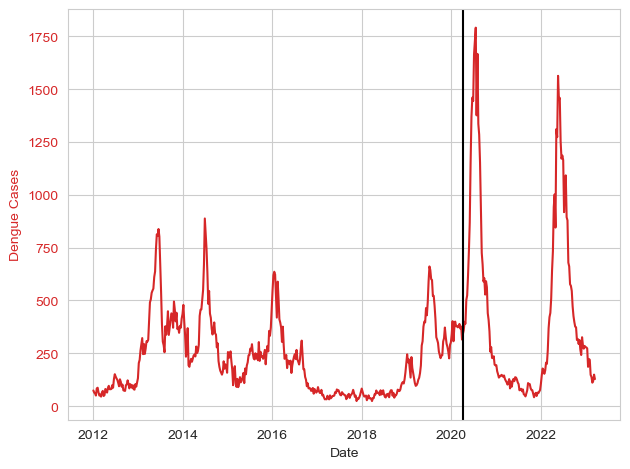

In [14]:
plot_timeseries(df2.index,df2.dengue_cases,'Dengue Cases','2020-04-03','Circuit Breaker')

### 3.2 Observing the months with highest dengue cases, rainfall and temperature using bar plot (2018 to 2023)
* Dengue cases usually peaks in the months of May to August
* Overlaps with the time of lower rainfall and warmer temperatures conducive for mosquito growth and activity
* Dengue cases are significantly higher post-covid
* Typically, May to August is the spike of dengue cases every year
* The width of the dengue spikes is about 3-4 months

In [15]:
data = df['Daily Rainfall Total (mm)'].groupby(df.index.month).mean()
data.head()

time
1    7.668323
2    3.674286
3    7.416541
4    6.351429
5    5.621118
Name: Daily Rainfall Total (mm), dtype: float64

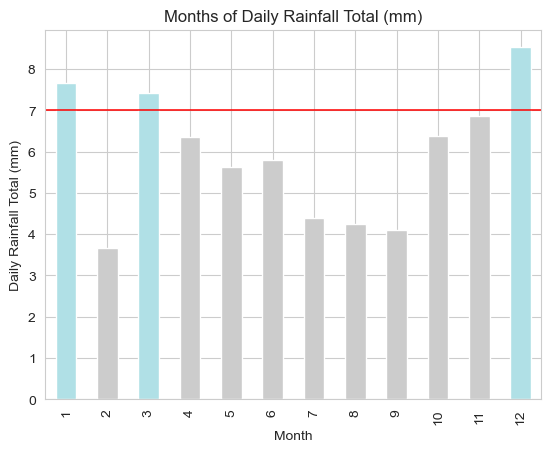

In [16]:
single_variable_barplot(df,'Daily Rainfall Total (mm)','powderblue',0.75)

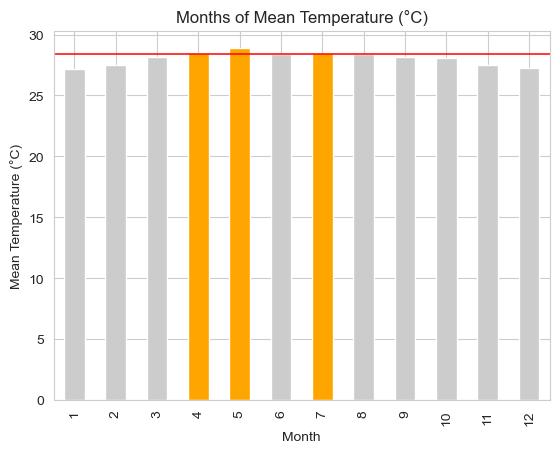

In [17]:
single_variable_barplot(df,'Mean Temperature (°C)','orange',0.75)

Text(0.5, 1.0, 'Dengue cases from 2012 to 2023')

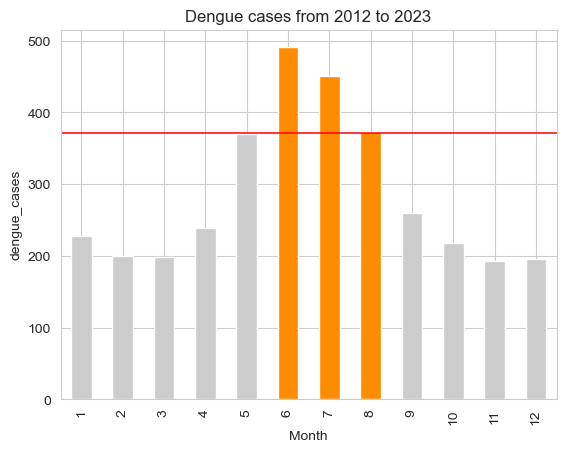

In [18]:
single_variable_barplot(df2,'dengue_cases','darkorange',0.75)
plt.title('Dengue cases from 2012 to 2023')

### 3.3 Temperature
* Mean temperature seems to be a left-skewed distribution
* The temperature fits the optimum average temperature for mosquito growth and activity at 25–30 °C according to https://www.sciencedirect.com/science/article/pii/S0213911121002399?via%3Dihub
* The temperature is also optimal for replication of dengue virus in the mosquito
* Temperature do not determine how high the spikes will be every year

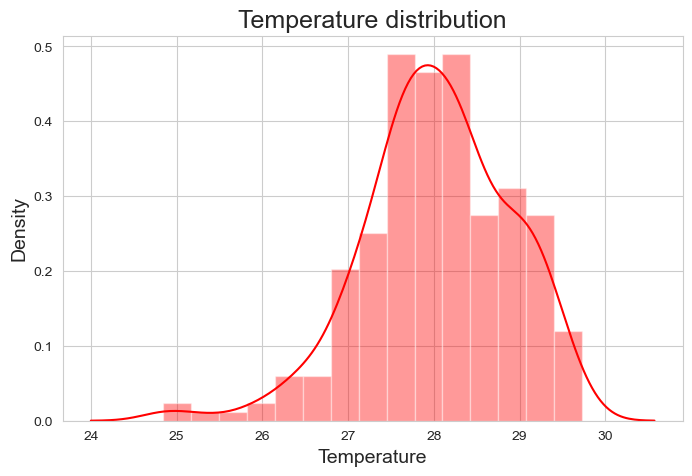

In [19]:
plt.figure(figsize=(8,5))
sns.distplot(df['Mean Temperature (°C)'],color='r')
plt.title('Temperature distribution',size=18)
plt.xlabel('Temperature',size=14)
plt.ylabel('Density',size=14)
plt.show()

In [20]:
temp_unstacked = unstacked[[('Mean Temperature (°C)', 2018),
            (    'Mean Temperature (°C)', 2019),
            (    'Mean Temperature (°C)', 2020),
            (    'Mean Temperature (°C)', 2021),
            (    'Mean Temperature (°C)', 2022),
            (    'Mean Temperature (°C)', 2023)]]
temp_unstacked.head()

Mean Temperature (°C)                                              \
year                         2018       2019       2020       2021       2022   
week_number                                                                     
1                             NaN  28.614286  27.814286  25.314286  27.428571   
2                             NaN  28.314286  27.157143  26.214286  27.557143   
3                             NaN  27.471429  27.971429  26.414286  27.514286   
4                             NaN  27.642857  27.971429  26.885714  27.871429   
5                             NaN  27.814286  27.900000  27.071429  28.057143   

                        
year              2023  
week_number             
1            27.414286  
2            27.142857  
3            27.000000  
4            24.842857  
5            26.057143

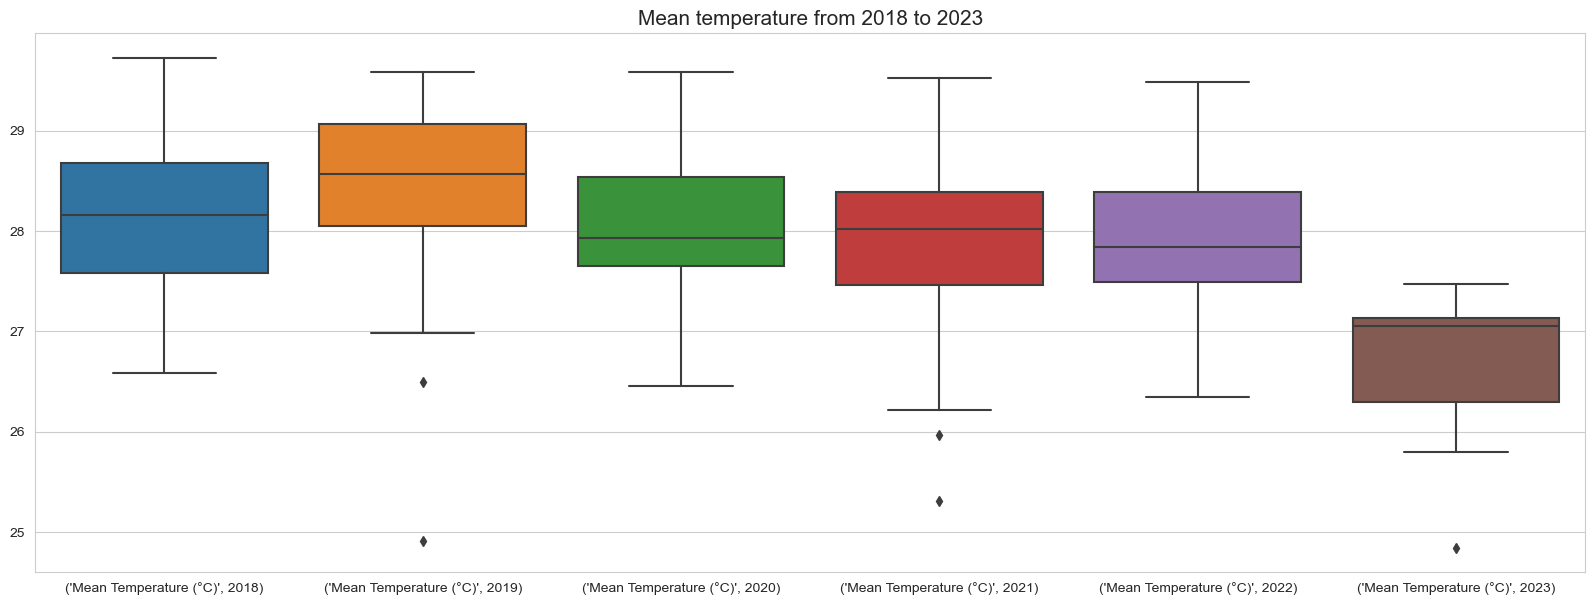

In [21]:
plt.figure(figsize = (20,7))
sns.boxplot(temp_unstacked)
plt.title('Mean temperature from 2018 to 2023',size=15)
plt.show()

### 3.4 Rainfall
* Higher rainfall might create more stagnant water for mosquito to reproduce
* Around 5mm daily rainfall (Averaged by week)
* 2019,2021 weeks with very high rainfall above 40 mm on average

In [22]:
rain_unstacked = unstacked[[('Daily Rainfall Total (mm)', 2018),
            ('Daily Rainfall Total (mm)', 2019),
            ('Daily Rainfall Total (mm)', 2020),
            ('Daily Rainfall Total (mm)', 2021),
            ('Daily Rainfall Total (mm)', 2022),
            ('Daily Rainfall Total (mm)', 2023)]]
rain_unstacked.head()

Daily Rainfall Total (mm)                                 \
year                             2018      2019      2020       2021   
week_number                                                            
1                                 NaN  5.600000  0.000000  40.085714   
2                                 NaN  0.914286  2.600000   2.485714   
3                                 NaN  7.771429  0.000000   4.628571   
4                                 NaN  0.285714  2.028571   1.685714   
5                                 NaN  0.142857  8.000000   0.000000   

                                  
year             2022       2023  
week_number                       
1            1.685714   1.800000  
2            0.000000   2.200000  
3            1.285714   7.714286  
4            0.542857  28.400000  
5            3.085714   8.171429

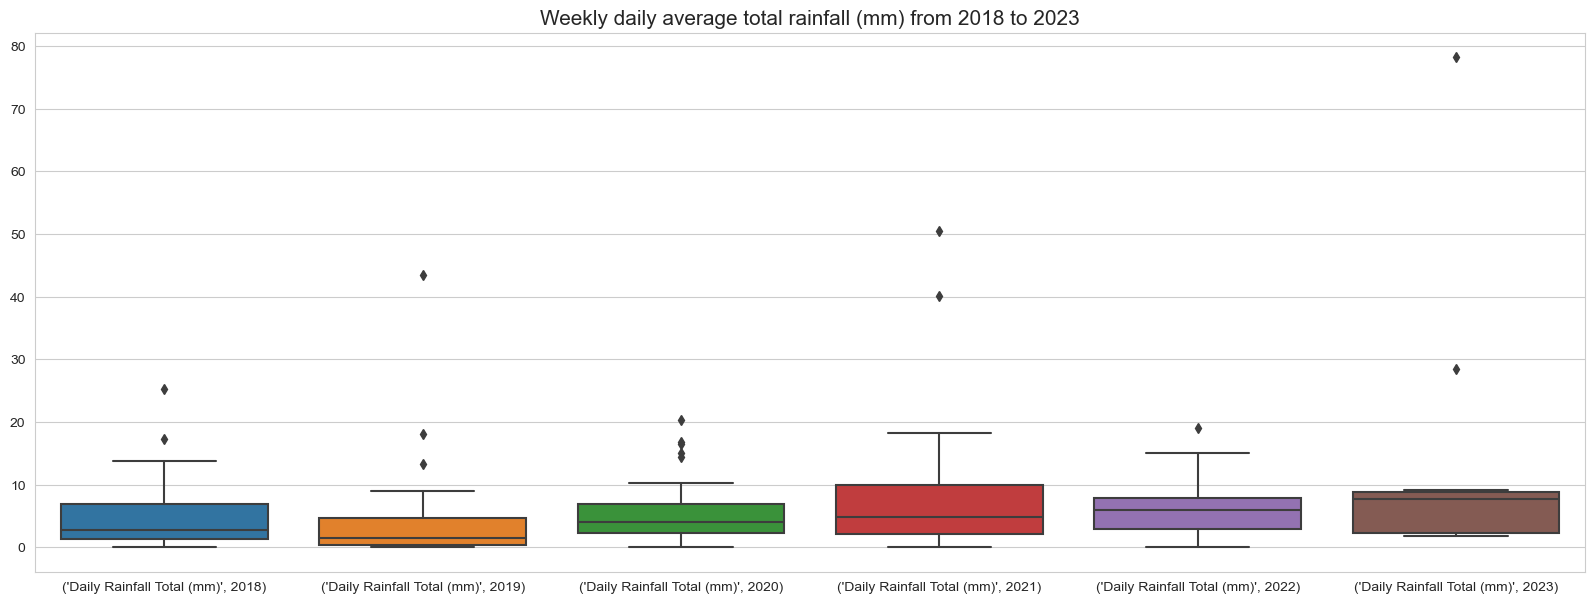

In [23]:
plt.figure(figsize = (20,7))
sns.boxplot(rain_unstacked)
plt.title('Weekly daily average total rainfall (mm) from 2018 to 2023',size=15)
plt.show()

### 3.5 Wind speed
* Wind speeds may reduce mosquito population as it affects flying and stagnant water.

In [24]:
wind_unstacked = unstacked[[('Mean Wind Speed (km/h)', 2018),
            ('Mean Wind Speed (km/h)', 2019),
            ('Mean Wind Speed (km/h)', 2020),
            ('Mean Wind Speed (km/h)', 2021),
            ('Mean Wind Speed (km/h)', 2022),
            ('Mean Wind Speed (km/h)', 2023)]]
wind_unstacked.head()

Mean Wind Speed (km/h)                                   \
year                          2018       2019       2020       2021   
week_number                                                           
1                              NaN   9.257143  12.128571   7.428571   
2                              NaN  12.385714   9.828571  11.985714   
3                              NaN   9.314286  12.171429  11.157143   
4                              NaN  12.700000  13.585714  11.357143   
5                              NaN  12.585714  12.942857  12.942857   

                                   
year              2022       2023  
week_number                        
1             8.814286   8.685714  
2            11.842857   7.642857  
3            10.942857  10.642857  
4             9.885714   8.828571  
5            11.314286   9.785714

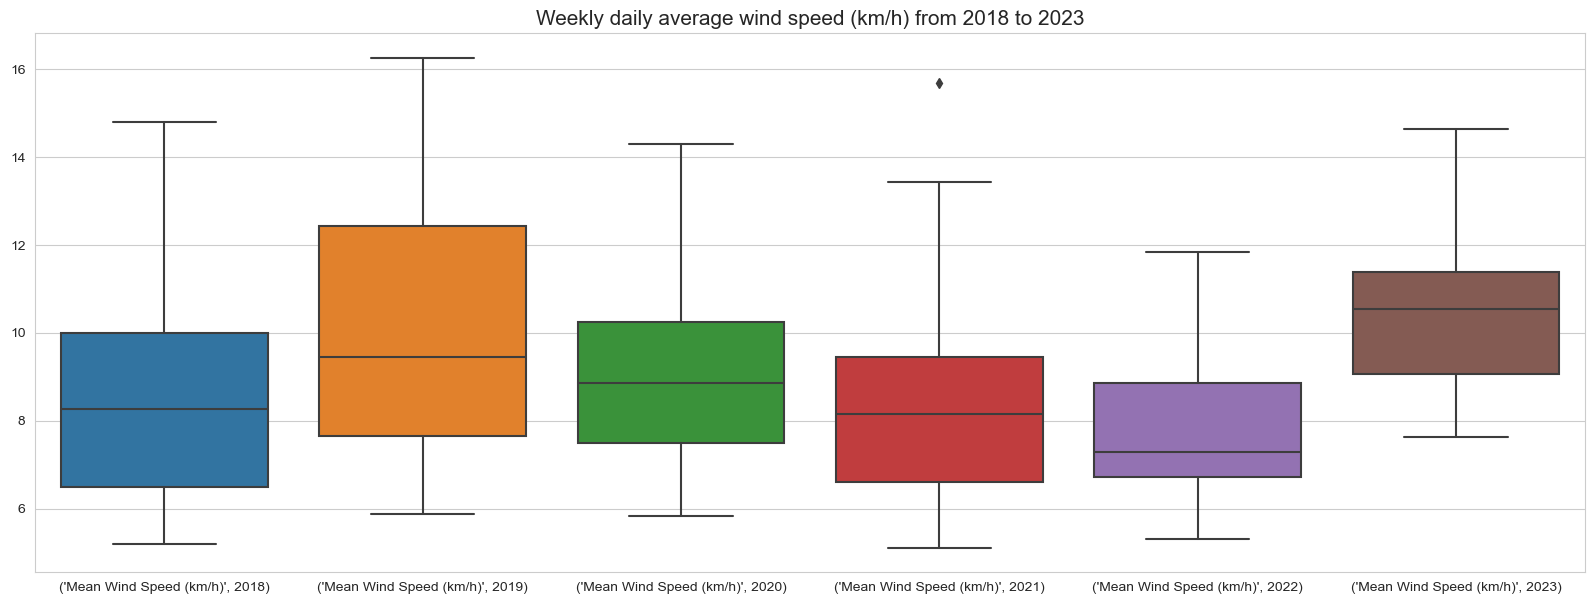

In [25]:
plt.figure(figsize = (20,7))
sns.boxplot(wind_unstacked)
plt.title('Weekly daily average wind speed (km/h) from 2018 to 2023',size=15)
plt.show()

### 3.6 Dengue cases
* Dengue cases every year is very different
* From the box plot, we can see dengue spikes in 2019, 2020 (largest spike) and 2022.
* Majority of the weeks, the dengue case count is below 500

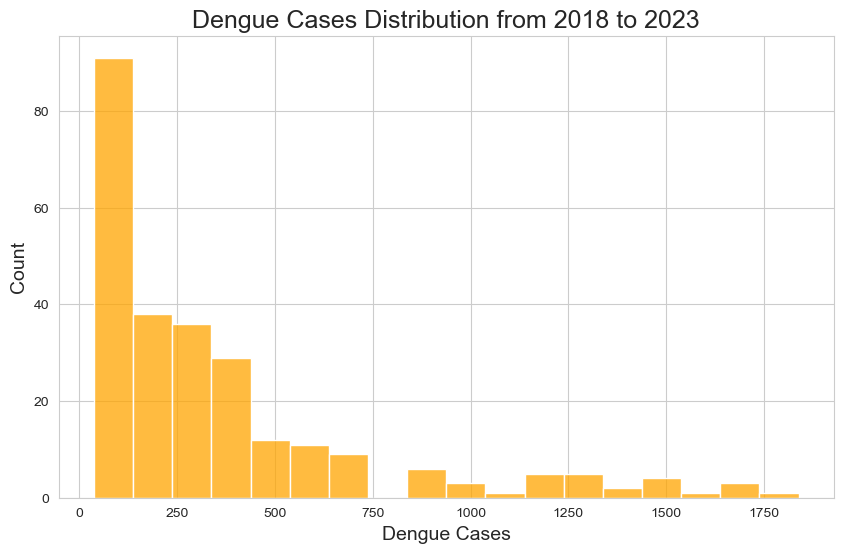

In [26]:
plt.figure(figsize=(10,6))
sns.histplot(df['dengue_cases'],color='orange', binwidth = 100)
plt.title('Dengue Cases Distribution from 2018 to 2023',size=18)
plt.xlabel('Dengue Cases',size=14)
plt.ylabel('Count',size=14)
plt.show()

In [27]:
dengue_unstacked = unstacked[[('dengue_cases', 2018),
            ('dengue_cases', 2019),
            ('dengue_cases', 2020),
            ('dengue_cases', 2021),
            ('dengue_cases', 2022),
            ('dengue_cases', 2023)]]
dengue_unstacked.head()

dengue_cases                                   
year                2018   2019   2020   2021   2022   2023
week_number                                                
1                    NaN  245.0  342.0  165.0  146.0  278.0
2                    NaN  207.0  402.0  151.0  178.0  273.0
3                    NaN  221.0  307.0  135.0  169.0  186.0
4                    NaN  179.0  370.0  141.0  153.0  223.0
5                    NaN  135.0  400.0  142.0  168.0  219.0

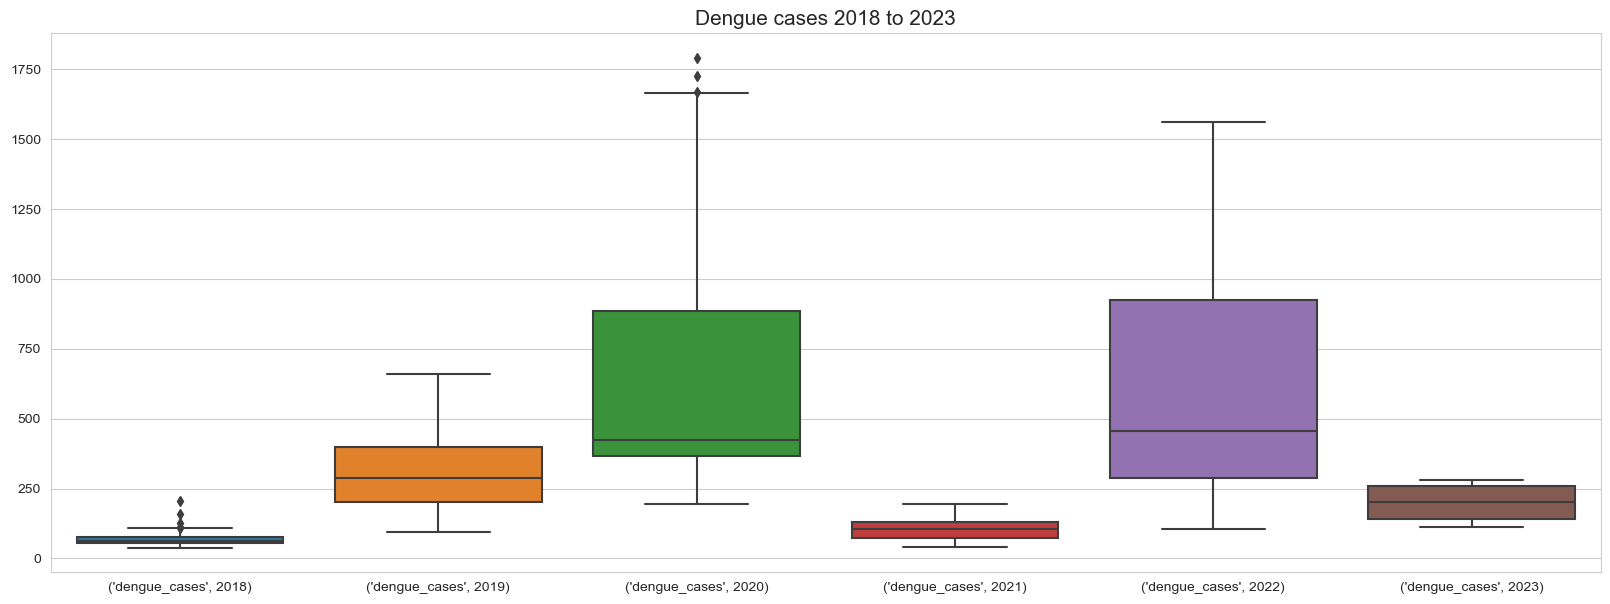

In [28]:
plt.figure(figsize = (20,7))
sns.boxplot(dengue_unstacked)
plt.title('Dengue cases 2018 to 2023',size=15)
plt.show()

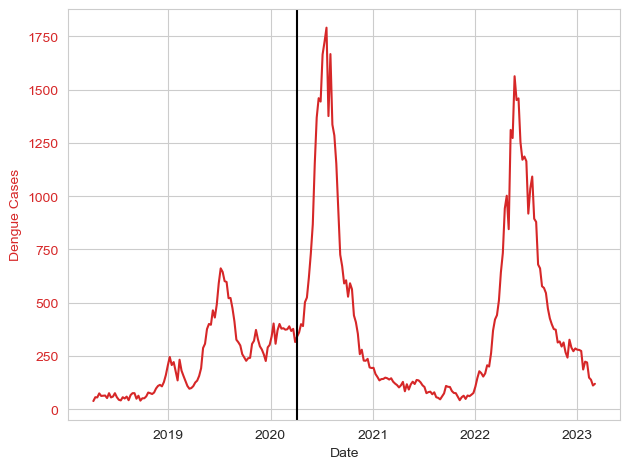

In [29]:
plot_timeseries(df.index,df.dengue_cases,'Dengue Cases','2020-04-03','Circuit Breaker')

## 4. Comparing 2 variables - Dengue cases vs Google Trends From 2018-2023

* Bivariate analysis to find relationships between two variables.
* boxplot(categorical vs numerical)
* scatterplot or line plot (numerical vs numerical)
* The google trends spikes matches the dengue spikes

### 4.1 Comparing dengue cases and google trends
* The spikes matches in time between dengue_cases and google_trends

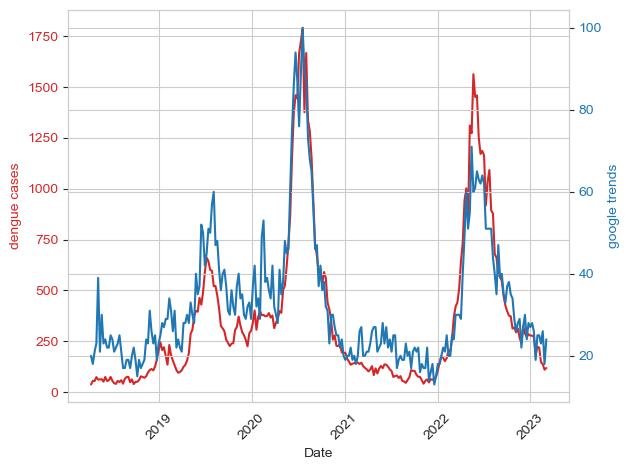

In [30]:
x=df.index
y1=df.dengue_cases
y2=df.google_trends

compare_timeseries(x,y1,'dengue cases',x,y2,'google trends')

* The 2 spikes are significantly higher than spike in 2019 after circuit breaker in 2020 April
* Vertical line is plotted on 3-Apr-23, the start of cirvuit breaker in Singapore

### 4.2 Find correlation between features and dengue cases time series for 2018 to 2023
* High correlation between dengue_cases and google_trends
* Negative correlation between Mean temperature and rainfall


In [31]:
features = ['Mean Temperature (°C)', 'Mean Wind Speed (km/h)',
       'Daily Rainfall Total (mm)', 'Maximum Temperature (°C)',
       'Max Wind Speed (km/h)', 'Minimum Temperature (°C)','dengue_cases','google_trends']

In [32]:
dataCorr = df[features].corr(method='pearson')
dataCorr = dataCorr.mask(np.tril(np.ones(dataCorr.shape)).astype(np.bool))
dataCorr = dataCorr[abs(dataCorr) >= 0.3].stack().reset_index()
print (dataCorr)

                     level_0                    level_1         0
0      Mean Temperature (°C)  Daily Rainfall Total (mm) -0.519492
1      Mean Temperature (°C)   Maximum Temperature (°C)  0.642291
2      Mean Temperature (°C)   Minimum Temperature (°C)  0.482721
3     Mean Wind Speed (km/h)   Minimum Temperature (°C)  0.372634
4  Daily Rainfall Total (mm)   Minimum Temperature (°C) -0.446208
5               dengue_cases              google_trends  0.930977


### 4.3 Checking smoothening effect using rolling window average

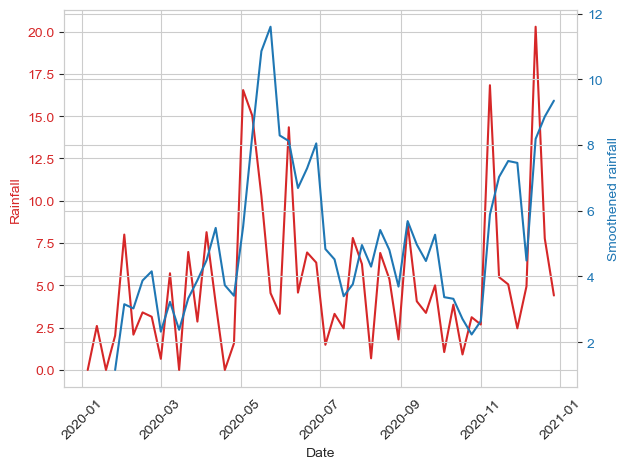

In [33]:
compare_timeseries(df[df['year']==2020].index,
                   df[df['year']==2020]['Daily Rainfall Total (mm)'],
                   'Rainfall',
                   df[df['year']==2020].index,
                   df[df['year']==2020]['Daily Rainfall Total (mm)'].rolling(4).mean(),
                   'Smoothened rainfall')

In [34]:
def compare_features(year1,year2,feature1,feature2,window):
    '''
    Function to compare feature 1 and feature 2 time series
    year1 : start year
    year2 : end year
    feature1: time series for first feature
    feature2: time series for second feature
    window: No of weeks for rolling average to smoothen the curve
    '''
    compare_timeseries(df[(df['year']>=year1) & (df['year']<=year2)].index,
                   df[(df['year']>=year1) & (df['year']<=year2)][feature1].rolling(window).mean(),
                   feature1,
                   df[(df['year']>=year1) & (df['year']<=year2)].index,
                   df[(df['year']>=year1) & (df['year']<=year2)][feature2].rolling(window).mean(),
                   feature2)

### 4.4 Zoom and visualise the correlation between temperature and rainfall
* Smooth out the series with rolling window of 4 weeks
* Positive Correlation between minimum temperature and rainfall
* Negative Correlation between mean temperature and rainfall

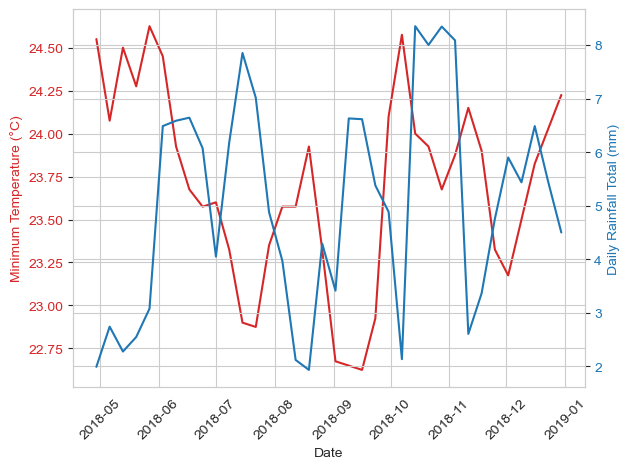

In [35]:
compare_features(2018,2018,'Minimum Temperature (°C)','Daily Rainfall Total (mm)',4)

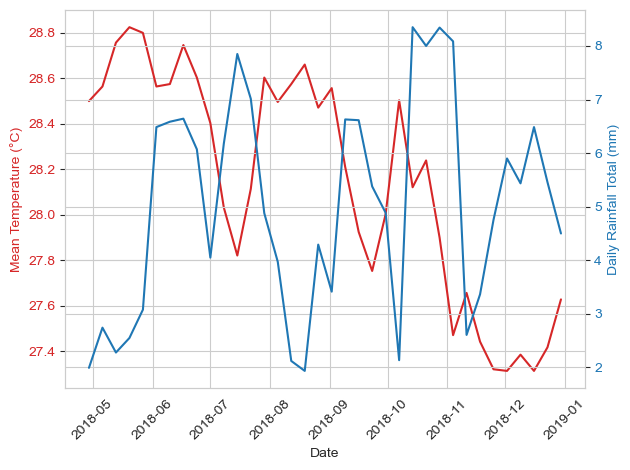

In [36]:
compare_features(2018,2018,'Mean Temperature (°C)','Daily Rainfall Total (mm)',4)

### 4.5 Zooming and find relationship between rainfall and dengue cases
* Smooth out the series with rolling window of 4 weeks
* As per above findings, there is little correlation between rainfall and dengue cases
* There is a one month negative lag, usally a period of higher rainfall precedes before dengue cases spikes

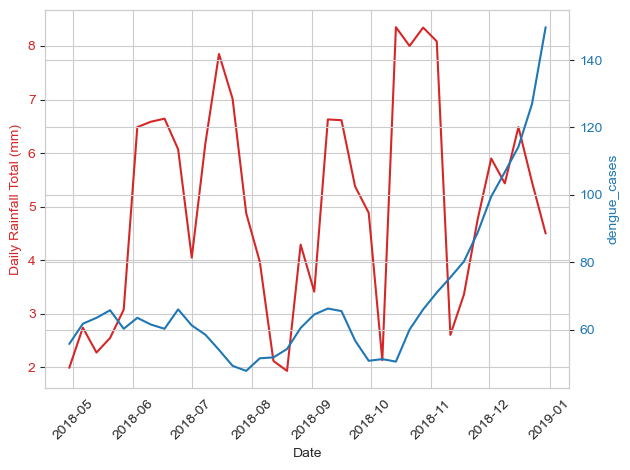

In [37]:
compare_features(2018,2018,'Daily Rainfall Total (mm)','dengue_cases',4)

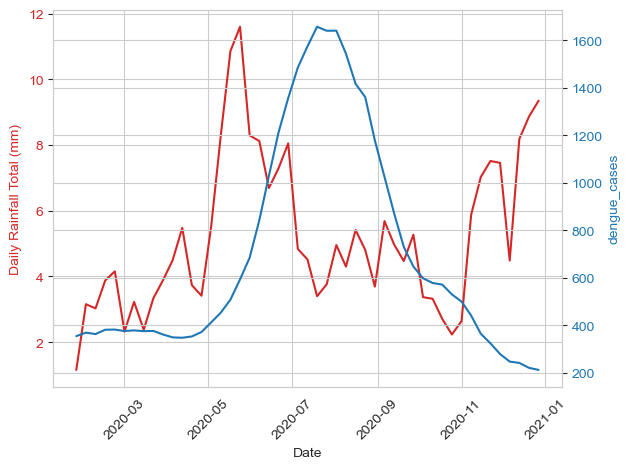

In [38]:
compare_features(2020,2020,'Daily Rainfall Total (mm)','dengue_cases',4)

### 4.6 Observing the lag time between Periods of high rainfall and dengue cases
* Dengue spikes precedes with high rainfall
* Life cycle of a mosquito is 42 – 56 days for an adult female mosquito
* 8-10 days from egg to larva to pupa to adult mosquito
* Around 1 month as adult mosquito
* High rainfall usually starts 1 month before the spike in dengue cases
* Sometimes high rainfall will not result in spikes
* High temperature coincides with dengue spikes

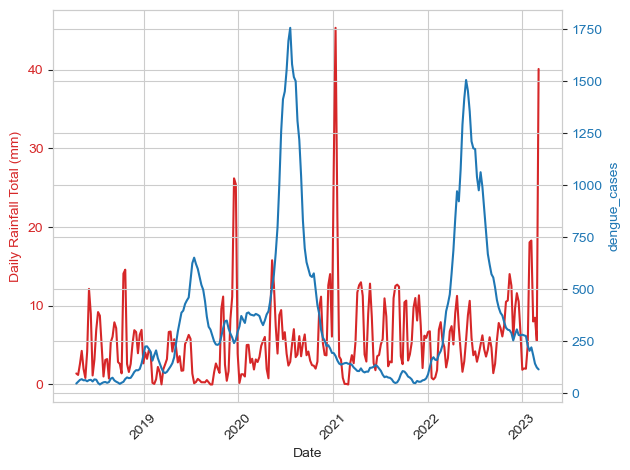

In [39]:
compare_features(2018,2023,'Daily Rainfall Total (mm)','dengue_cases',2)

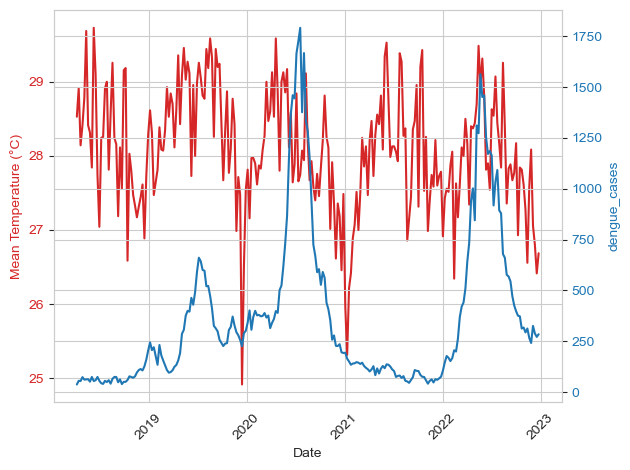

In [40]:
# Weather factors can help to predict dengue outbreaks
compare_features(2018,2022,'Mean Temperature (°C)','dengue_cases',1)

## 5. Sifting the Trend, seasonal and error component of the time series
* Seasonal pattern: Usually peaks in July 
* Abnormally high in 2020 and 2022 July
* No peaks in 2021 July

### 5.1 Dengue time series decomposition from 2018-2023

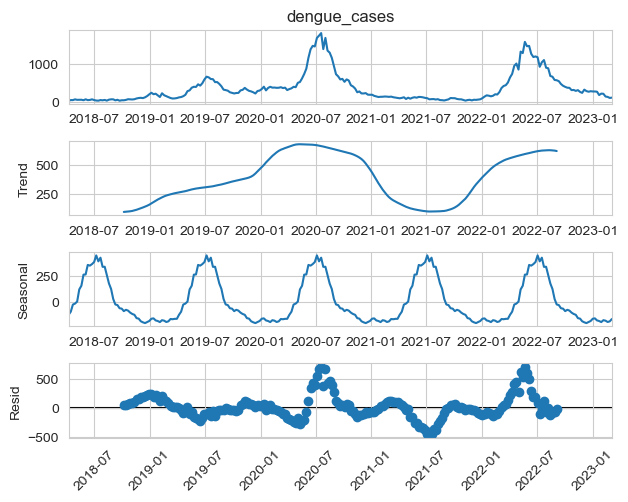

In [41]:
# 2018-2023
result = seasonal_decompose(df.dengue_cases, model='additive')
result.plot()
plt.xticks(rotation=45)
plt.show()

### 5.2 Dengue time series decomposition from 2012-2023

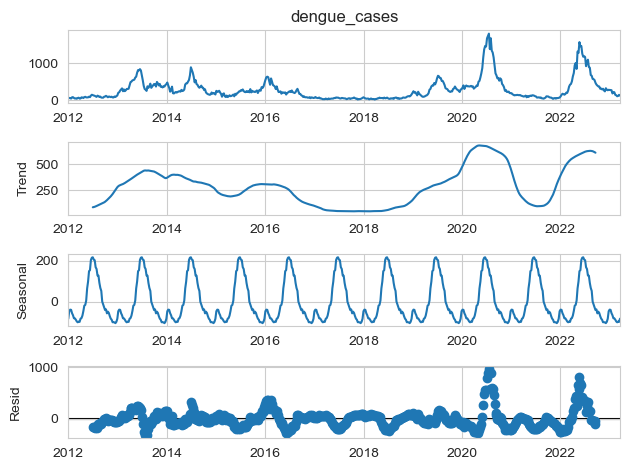

In [42]:
# 2012-2023
result = seasonal_decompose(df2.dengue_cases, model='additive')
result.plot()
plt.show()

### 5.3 Google trends time series decomposition from 2018-2023

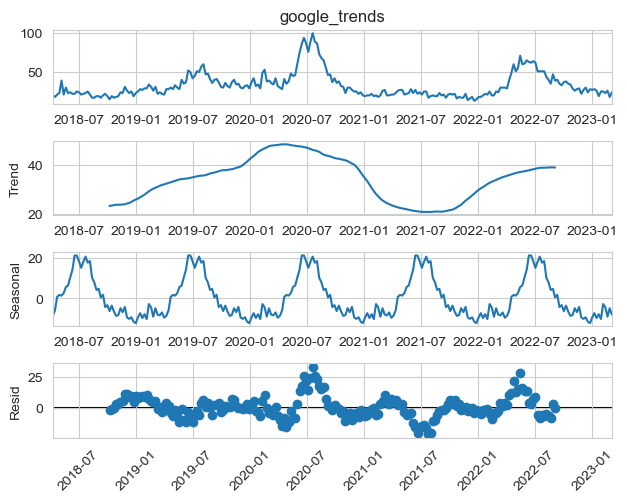

In [43]:
result = seasonal_decompose(df.google_trends, model='additive')
result.plot()
plt.xticks(rotation=45)
plt.show()

### 5.4 Google trend time series decomposition from 2012-2023 (Monthly)
* Using the extended data for monthy google trends from 2012 to 2023, we can see a similar trend with dengue cases
* There is a spike in July 2016 for google searches without a corresponding significant increase in dengue cases

In [44]:
ts = pd.read_csv('../datasets/dengue_search_trends/defined_queries_2012_2023.csv', skiprows=2)
ts['Month'] = pd.to_datetime(ts['Month'], format = '%Y-%m-%d')
ts.set_index('Month',inplace=True)
ts.rename(columns={ ts.columns[0]: "google_trend" }, inplace = True)
ts.head()

,google_trend
Month,
2012-01-01,16
2012-02-01,17
2012-03-01,15
2012-04-01,18
2012-05-01,17


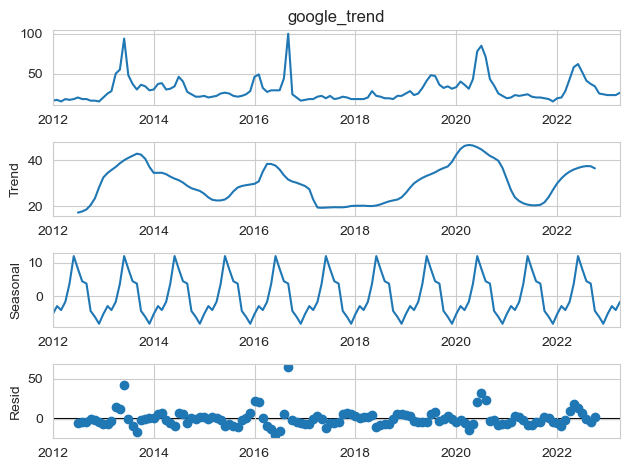

In [45]:
result = seasonal_decompose(ts.google_trend, model='additive')
result.plot()
plt.show()

### 5.5 Serology time series decomposition from 2018-2023
* DENV_3 is the dominant strain from 2021 onwards
* DENV_2 percentage is falling due to immunity 

In [46]:
df.columns

Index(['dengue_cases', 'denv_1', 'denv_2', 'denv_3', 'denv_4',
       'Mean Temperature (°C)', 'Mean Wind Speed (km/h)',
       'Daily Rainfall Total (mm)', 'Maximum Temperature (°C)',
       'Max Wind Speed (km/h)', 'Minimum Temperature (°C)', 'google_trends',
       'year', 'date', 'week_number'],
      dtype='object')

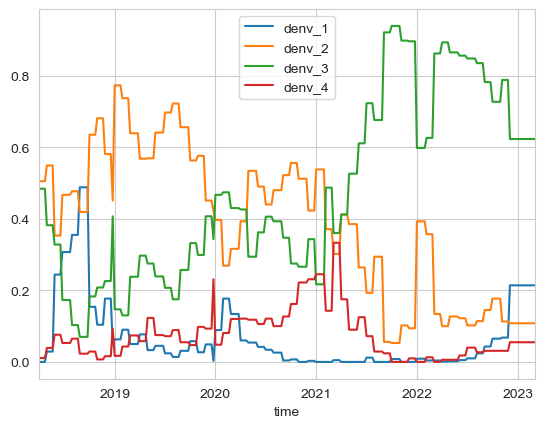

In [47]:
serology = df[['denv_1', 'denv_2', 'denv_3', 'denv_4']]
serology.plot()
plt.show()

* Abnormally high spikes in July 2020 and 2022 is due to DENV_3
* DENV_3 is dropping in 2023

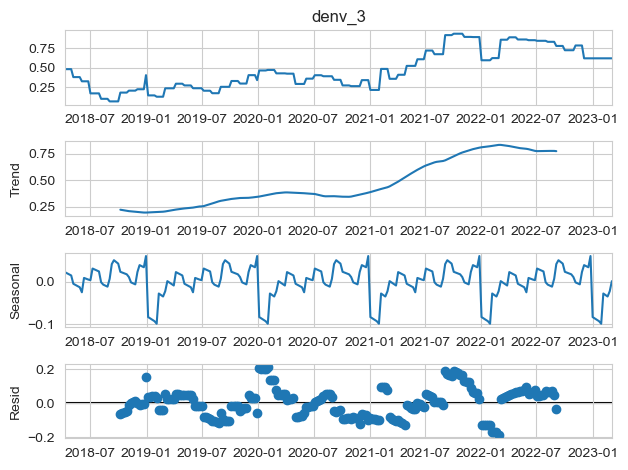

In [48]:
result = seasonal_decompose(df.denv_3, model='additive')
result.plot()
plt.show()

* DENV_1 is rising in 2023
* Subsequent dengue spikes in 2023 maybe a mixture of DENV_3 and DENV_1 cases

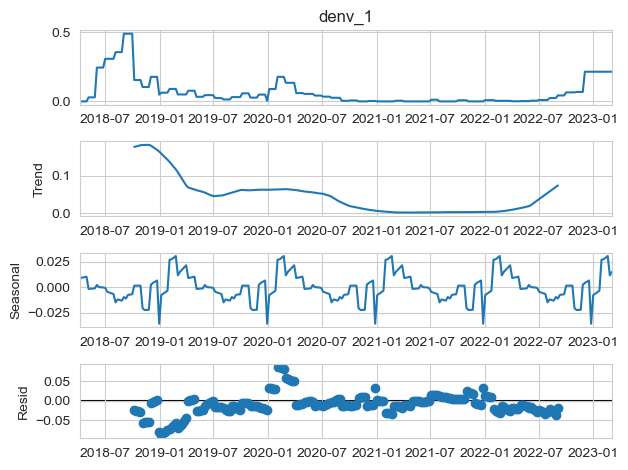

In [49]:
result = seasonal_decompose(df.denv_1, model='additive')
result.plot()
plt.show()

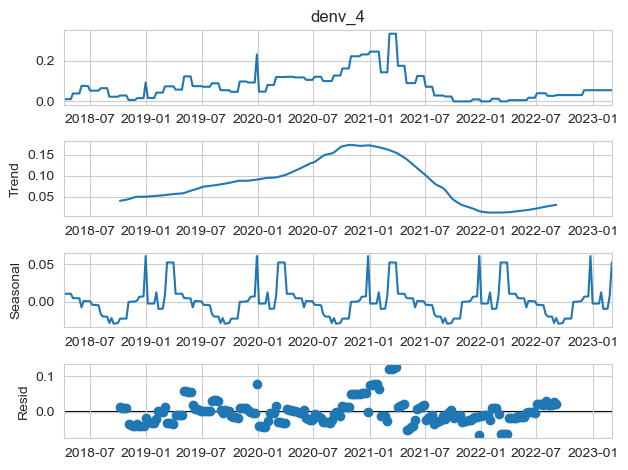

In [50]:
result = seasonal_decompose(df.denv_4, model='additive')
result.plot()
plt.show()

In [51]:
df.columns

Index(['dengue_cases', 'denv_1', 'denv_2', 'denv_3', 'denv_4',
       'Mean Temperature (°C)', 'Mean Wind Speed (km/h)',
       'Daily Rainfall Total (mm)', 'Maximum Temperature (°C)',
       'Max Wind Speed (km/h)', 'Minimum Temperature (°C)', 'google_trends',
       'year', 'date', 'week_number'],
      dtype='object')

In [52]:
round(df.dengue_cases*df.denv_3)

time
2018-04-08     18.0
2018-04-15     27.0
2018-04-22     27.0
2018-04-29     36.0
2018-05-06     24.0
              ...  
2023-02-05    136.0
2023-02-12     92.0
2023-02-19     86.0
2023-02-26     69.0
2023-03-05     74.0
Length: 257, dtype: float64

In [53]:
def dengue_by_serology(df,color,t1,t2):
    
    ''' 
    Function to plot stacked plots of dengue cases stratified by serology of DENV 1-4
    df: dataframe
    color: colour palette for denv strains
    t1: quantile threshold 1 e.g. 0.75
    t2. quantile threshold 2 e.g. 0.95
    '''   
    plt.figure(figsize=(12, 6))

    threshold_1 = round(df.dengue_cases.quantile(t1))
    threshold_2 = round(df.dengue_cases.quantile(t2))
    
    x = df.index
    y1= round(df.dengue_cases*df.denv_1)
    y2= round(df.dengue_cases*df.denv_2)
    y3= round(df.dengue_cases*df.denv_3)
    y4= round(df.dengue_cases*df.denv_4)
    
    # Create stackplot
    plt.stackplot(x,y3,y2,y1,y4,
                  labels=['denv_3','denv_2','denv_1','denv_4'], colors=color, alpha=0.7)
    
    plt.axhline(threshold_1, color='orange', linestyle='solid', linewidth=1.1,label=f'{round(t1*100)}th percentile ({round(threshold_1)} cases)')

    plt.axhline(threshold_2, color='red', linestyle='solid', linewidth=1.1, label=f'{round(t2*100)}th percentile ({round(threshold_2)} cases)')
       
    plt.legend(loc='upper left')
    plt.margins(0,0)
    plt.xlim(df.index.min(), df.index.max())
    plt.title('Dengue fever weekly cases, by serology')
    plt.ylabel('Case count')
    plt.xlabel('Date')
    plt.tick_params() ;

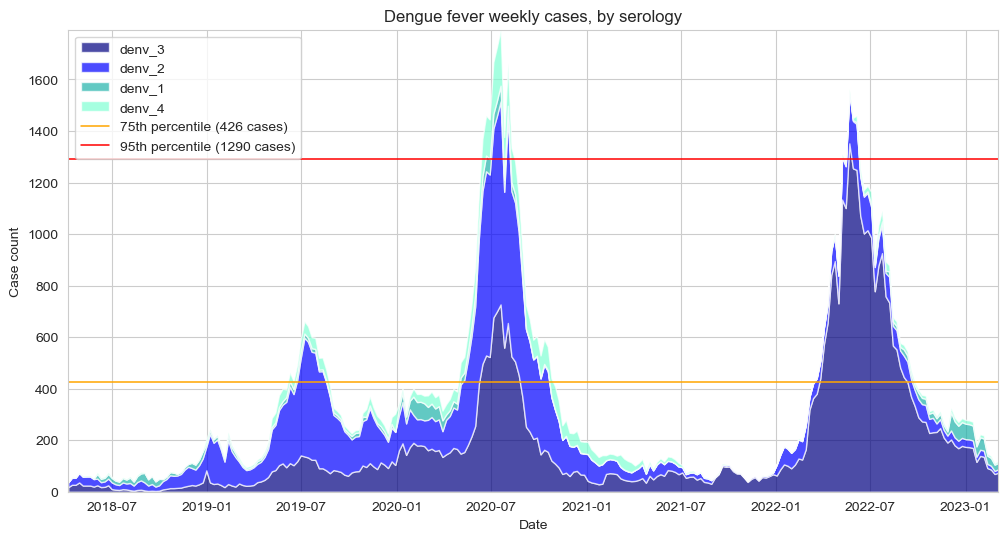

In [54]:
color = ['navy','blue','lightseagreen','aquamarine']
dengue_by_serology(df,color,0.75, 0.95)

## 6. Effects of time lags on correlations of multivariables

In [55]:
features = ['denv_1', 'denv_2', 'denv_3', 'denv_4',
       'Mean Temperature (°C)', 'Mean Wind Speed (km/h)',
       'Daily Rainfall Total (mm)', 'Maximum Temperature (°C)',
       'Max Wind Speed (km/h)', 'Minimum Temperature (°C)', 'google_trends']

In [56]:
shifted = df[features].shift(periods=2)
shifted.head()

,denv_1,denv_2,denv_3,denv_4,Mean Temperature (°C),Mean Wind Speed (km/h),Daily Rainfall Total (mm),Maximum Temperature (°C),Max Wind Speed (km/h),Minimum Temperature (°C),google_trends
time,,,,,,,,,,,
2018-04-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-22,0.0,0.505,0.484,0.011,28.528571,10.714286,0.742857,33.8,36.7,25.5,20.0
2018-04-29,0.0,0.505,0.484,0.011,28.914286,9.828571,2.057143,34.4,38.2,24.6,18.0
2018-05-06,0.0,0.505,0.484,0.011,28.142857,7.700000,0.371429,34.3,37.1,25.5,21.0


In [57]:
target = df['dengue_cases']
target.head()

time
2018-04-08    38
2018-04-15    56
2018-04-22    55
2018-04-29    74
2018-05-06    62
Name: dengue_cases, dtype: int64

In [58]:
data_corr = pd.concat([shifted, target], axis=1)
data_corr.head()

,denv_1,denv_2,denv_3,denv_4,Mean Temperature (°C),Mean Wind Speed (km/h),Daily Rainfall Total (mm),Maximum Temperature (°C),Max Wind Speed (km/h),Minimum Temperature (°C),google_trends,dengue_cases
time,,,,,,,,,,,,
2018-04-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38
2018-04-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56
2018-04-22,0.0,0.505,0.484,0.011,28.528571,10.714286,0.742857,33.8,36.7,25.5,20.0,55
2018-04-29,0.0,0.505,0.484,0.011,28.914286,9.828571,2.057143,34.4,38.2,24.6,18.0,74
2018-05-06,0.0,0.505,0.484,0.011,28.142857,7.700000,0.371429,34.3,37.1,25.5,21.0,62


In [59]:
list(range(-10, 10+1))

[-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [60]:
def get_lag_corr(df_features,target,min_lag, max_lag):
    '''
    Function to get correlation for different time lags between the features
    df_features: data frame with features as columns
    target: target series
    min_lag: maximum negative lags in weeks
    max_lag: maximum postive lags in weeks
    '''
    corr_list = pd.DataFrame()
    
    # Correlation with lags
    for i in range(min_lag,max_lag+1):
        if i == 0:
            data = pd.concat([df_features, target], axis=1)
            row = data.corr()['dengue_cases']
            t_row = pd.DataFrame(row).transpose().rename(index={'dengue_cases': 0})
            corr_list = pd.concat([corr_list, t_row], axis=0)   
        shifted = df_features.shift(periods=i)
        data = pd.concat([shifted, target], axis=1)
        row = data.corr()['dengue_cases']
        t_row = pd.DataFrame(row).transpose().rename(index={'dengue_cases': i})
        corr_list = pd.concat([corr_list, t_row], axis=0)
        
    return corr_list

In [61]:
corr_list = get_lag_corr(
    df[['denv_1', 'denv_2', 'denv_3', 'denv_4',
       'Mean Temperature (°C)', 'Mean Wind Speed (km/h)',
       'Daily Rainfall Total (mm)', 'Maximum Temperature (°C)',
       'Max Wind Speed (km/h)', 'Minimum Temperature (°C)', 'google_trends']],
    df['dengue_cases'],-2,2)

In [62]:
corr_list.head()

,denv_1,denv_2,denv_3,denv_4,Mean Temperature (°C),Mean Wind Speed (km/h),Daily Rainfall Total (mm),Maximum Temperature (°C),Max Wind Speed (km/h),Minimum Temperature (°C),google_trends,dengue_cases
-2,-0.259507,-0.102571,0.179043,0.032520,0.131784,-0.049076,-0.068460,-0.059598,0.051402,0.046578,0.889838,1.0
-1,-0.257472,-0.104123,0.182358,0.022484,0.159847,-0.059330,-0.076092,-0.027577,0.036470,0.065636,0.920891,1.0
0,-0.254615,-0.105002,0.185131,0.011167,0.168341,-0.079553,-0.066408,-0.018892,0.028140,0.069802,0.930977,1.0
0,-0.254615,-0.105002,0.185131,0.011167,0.168341,-0.079553,-0.066408,-0.018892,0.028140,0.069802,0.930977,1.0
1,-0.252502,-0.106549,0.188619,-0.002353,0.181789,-0.090432,-0.046568,-0.000160,0.012032,0.076440,0.917511,1.0


In [63]:
corr_list[corr_list.columns[1]]

-2   -0.102571
-1   -0.104123
 0   -0.105002
 0   -0.105002
 1   -0.106549
 2   -0.107465
Name: denv_2, dtype: float64

In [64]:
def plot_lag_corr(df_features,target,min_lag,max_lag):
    '''
    Function to visualise correlation for different time lags between the features
    df_features: data frame with features as columns
    target: target series
    min_lag: maximum negative lags in weeks
    max_lag: maximum postive lags in weeks
    '''
    fig, axes = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(15,8))
    palette = ['k', 'm', 'b', 'c', 'g']
    corr_list = get_lag_corr(df_features,target,min_lag,max_lag)
        
    for i, ax in enumerate(axes.flatten()[:len(df_features.columns)]):
        col_index = i % 5
        ax.plot(corr_list[corr_list.columns[i]], color=palette[col_index])
        ax.set_xlabel('Lag (weeks)', size=10)
        ax.set_ylabel('Pearson correlation', size=10)
        ax.set_title(corr_list.columns[i], size=12)
        ax.tick_params(labelsize=10)
        ax.set_ylim(-1, 1)

    fig.suptitle(f'Correlation variations for different week lags over each feature', fontsize=15) 
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)

In [65]:
df.columns

Index(['dengue_cases', 'denv_1', 'denv_2', 'denv_3', 'denv_4',
       'Mean Temperature (°C)', 'Mean Wind Speed (km/h)',
       'Daily Rainfall Total (mm)', 'Maximum Temperature (°C)',
       'Max Wind Speed (km/h)', 'Minimum Temperature (°C)', 'google_trends',
       'year', 'date', 'week_number'],
      dtype='object')

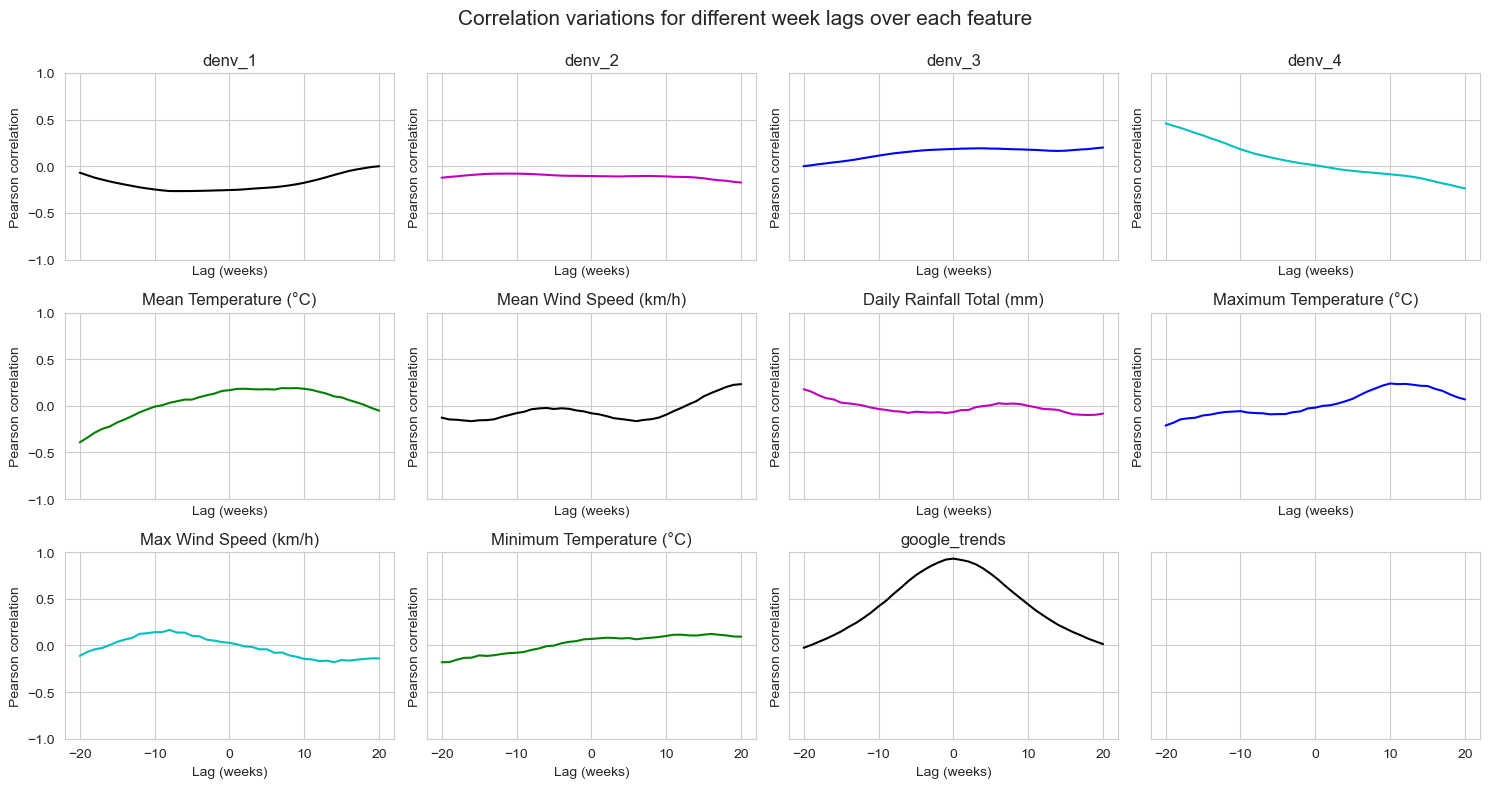

In [66]:
plot_lag_corr(df[['denv_1', 'denv_2', 'denv_3', 'denv_4',
       'Mean Temperature (°C)', 'Mean Wind Speed (km/h)',
       'Daily Rainfall Total (mm)', 'Maximum Temperature (°C)',
       'Max Wind Speed (km/h)', 'Minimum Temperature (°C)', 'google_trends']],df['dengue_cases'],-20,20)

**Findings of correlation of multiple features with dengue cases**
1. Google trends have the highest pearson correlation at time lag of 0 weeks
2. Mean temperature have consistent correlation at positive time lag of 0-10 weeks
3. Mean wind spead have some correlation at positive time lag of 20 weeks
4. Rainfall has some correlation at negative time lag of 20 weeks
5. Maximum temperature have higher correlation at positive time lag of 10 weeks